In [1]:

import torch
import sys
from torch.utils.data import DataLoader
from torchvision.transforms import Lambda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from data import DAGMDataset
from settings import TRAINING_LABEL_FILE_PATH, TEST_LABEL_FILE_PATH
import matplotlib.pyplot as plt
from torchvision.io import read_image
from tqdm.notebook import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class AEDataset(DAGMDataset):
    def __init__(self, meta_file, transform=None, target_transform=None, defect_only=False):
        super(AEDataset, self).__init__(meta_file,transform,target_transform, defect_only)

    def __getitem__(self,idx):
        img_path = self.meta_df["img_file"].iloc[idx]
        image = read_image(img_path).float()
        has_defect = self.meta_df["has_defect"].iloc[idx] == 1
        defect_mask_path = str(self.meta_df["label_file"].iloc[idx])
        if self.transform:
            image = self.transform(image)
        if has_defect:
            defect_mask = read_image(defect_mask_path).flatten().float()
        else:
            defect_mask = torch.zeros(512**2, dtype=torch.float)

        defect_mask[defect_mask!=0.]=1
        #defect_mask is a 512**2 binary tensor
        return image.float(), defect_mask.float()



In [3]:
transform = transforms.Normalize((0,), (255,))

batch_size=2
defect_only = True
training_set = AEDataset(meta_file=TRAINING_LABEL_FILE_PATH, transform=transform, defect_only=defect_only)
testing_set = AEDataset(meta_file=TEST_LABEL_FILE_PATH, transform=transform, defect_only=defect_only)
train_dataloader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testing_set, batch_size=batch_size, shuffle=True)

In [4]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.lyrs = torch.nn.ModuleList()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3,padding=1),
            nn.ReLU(),   
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3,padding=1),
            nn.ReLU(),   
        )

        self.layer3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128,kernel_size=3,padding=2,dilation=2),
            nn.ReLU(),
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3,padding=1),
            nn.ReLU(),   
        )

        self.layer6 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.layer7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256,kernel_size=3,padding=2,dilation=2),
            nn.ReLU(),
        )

        self.layer8 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3,padding=1),
            nn.ReLU(),   
        )

        self.layer9 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.layer10 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512,kernel_size=3,padding=4,dilation=4),
            nn.ReLU(),
        )

        self.layer11 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3,padding=1),
            nn.ReLU(),   
        )

        self.layer12 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.layer13 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024,kernel_size=3,padding=4,dilation=4),
            nn.ReLU(),
        )

        self.layer14 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3,padding=1),
            nn.ReLU(),
        )

        self.layer15 = nn.Upsample(scale_factor=2)

        self.layer16 = nn.Sequential(
            nn.Conv2d(in_channels=1536, out_channels=512, kernel_size=3,padding=1),
            nn.ReLU(),
        )

        self.layer17 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3,padding=1),
            nn.ReLU(),
        )

        self.layer18 = nn.Upsample(scale_factor=2)

        self.layer19 = nn.Sequential(
            nn.Conv2d(in_channels=768, out_channels=256, kernel_size=3,padding=1),
            nn.ReLU(),
        )

        self.layer20 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3,padding=1),
            nn.ReLU(),
        )

        self.layer21 = nn.Upsample(scale_factor=2)

        self.layer22 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=128, kernel_size=3,padding=1),
            nn.ReLU(),
        )

        self.layer23 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3,padding=1),
            nn.ReLU(),
        )

        self.layer24 = nn.Upsample(scale_factor=2)

        self.layer25 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=64, kernel_size=3,padding=1),
            nn.ReLU(),
        )

        self.layer26 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=2, kernel_size=1),
        )

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        y=x
        y=self.layer1(y)
        y=self.layer2(y)
        result2=y
        y=self.layer3(y)
        y=self.layer4(y)
        y=self.layer5(y)
        result5=y
        y=self.layer6(y)
        y=self.layer7(y)
        y=self.layer8(y)
        result8=y
        y=self.layer9(y)
        y=self.layer10(y)
        y=self.layer11(y)
        result11=y
        y=self.layer12(y)
        y=self.layer13(y)
        y=self.layer14(y)
        y=self.layer15(y)
        y=torch.cat((result11,y),1)
        y=self.layer16(y)
        y=self.layer17(y)
        y=self.layer18(y)
        y=torch.cat((y,result8),1)
        y=self.layer19(y)
        y=self.layer20(y)
        y=self.layer21(y)
        y=torch.cat((y,result5),1)
        y=self.layer22(y)
        y=self.layer23(y)
        y=self.layer24(y)
        y=torch.cat((y,result2),1)
        y=self.layer25(y)
        y=self.layer26(y)
        y = self.softmax(y)
        y = torch.flatten(y,2)
        return y[:,0]
    
    def learn(self,train_loader,optimizer,loss_fcn,epochs=30):
        train_loss_list = []
        for epoch in tqdm(range(epochs)):
            train_loss = 0.
            for i,(image, defect_mask) in enumerate(train_loader):
                image = image.to(device)
                defect_mask = defect_mask.to(device)
                output = self(image)
                loss = loss_fcn(output, defect_mask)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                #print(loss.item())
            train_loss = train_loss / len(train_loader)
            print("train_loss", train_loss)
            train_loss_list.append(train_loss)

In [5]:
class pixel_wise_ce_loss(nn.Module):
    def __init__(self):
        super(pixel_wise_ce_loss, self).__init__()

    def forward(self,output,defect_mask):
        output = torch.clamp(output,min=1e-7,max=1-1e-7)
        loss =  -0.8* defect_mask * torch.log(output) - 0.2*(1 - defect_mask)*torch.log(1 - output)
        return torch.mean(loss)

In [6]:
ae1 = autoencoder().to(device)
#loss_fcn = nn.BCELoss()
loss_fcn = pixel_wise_ce_loss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(ae1.parameters(),lr=learning_rate,amsgrad=True )
ae1.learn(train_dataloader,optimizer,loss_fcn,epochs=30)

  0%|          | 0/30 [00:00<?, ?it/s]

train_loss 0.06047078266376576


KeyboardInterrupt: 

In [7]:
def draw(img):
    with torch.no_grad():
        plt.imshow(img.cpu().numpy().reshape((512,512)), cmap='gray');
        plt.axis('off');

In [ ]:
# with torch.no_grad():
#     plt.figure(figsize=(14,7))
#     ae1.to(device)
#     image, defect_mask = next(iter(test_dataloader))
#     defect_mask=defect_mask.to(device)
#     image = image.to(device)
#     output = ae1(image)
#     plt.subplot(1,2,1); draw(defect_mask[0]);
#     plt.subplot(1,2,2); draw(output[0]);


In [8]:
torch.save(ae1.state_dict(), 'ae1.pt')

In [9]:
class autoencoder2(autoencoder):
    def __init__(self,ae1):
        super(autoencoder2, self).__init__()
    
    def learn(self,train_loader,optimizer,loss_fcn,epochs=20):
        train_loss_list = []
        for epoch in tqdm(range(epochs)):
            train_loss = 0.
            for i,(image, defect_mask) in enumerate(train_loader):
                image = ae1(image.to(device)).reshape(batch_size,-1,512,512)
                defect_mask = defect_mask.to(device)
                output = self(image)
                loss = loss_fcn(output, defect_mask)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            train_loss = train_loss / len(train_loader)
            print("train_loss", train_loss)
            train_loss_list.append(train_loss)

In [10]:
ae2 = autoencoder2(ae1).to(device)
#loss_fcn = nn.BCELoss()
loss_fcn = pixel_wise_ce_loss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(ae2.parameters(),lr=learning_rate,amsgrad=True )
ae2.learn(train_dataloader,optimizer,loss_fcn,epochs=20)

  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

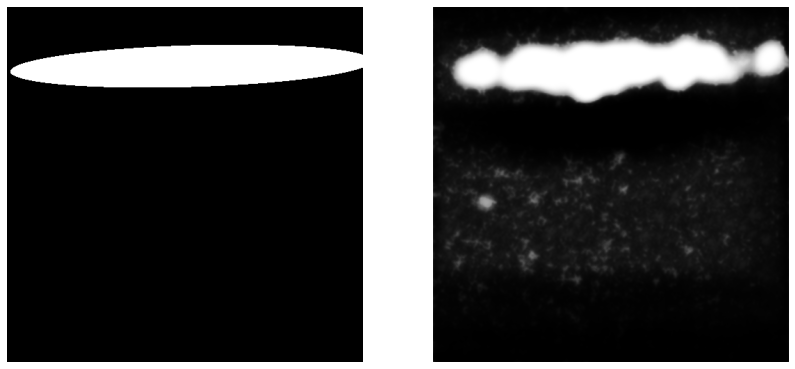

In [11]:
with torch.no_grad():
    plt.figure(figsize=(14,7))
    ae1.to(device)
    image, defect_mask = next(iter(test_dataloader))
    defect_mask=defect_mask.to(device)
    image = image.to(device)
    output = ae1(image)
    plt.subplot(1,2,1); draw(defect_mask[0]);
    plt.subplot(1,2,2); draw(output[0]);

In [12]:
torch.save(ae2.state_dict(), 'ae2.pt')

In [13]:
class CASAE(nn.Module):
    def __init__(self,ae1,ae2):
        super(CASAE, self).__init__()
        self.ae1 = ae1
        self.ae2 = ae2

    def forward(self,input):
        y = input
        y = self.ae1(y).reshape(batch_size,1,512,512)
        y = self.ae2(y)
        return y


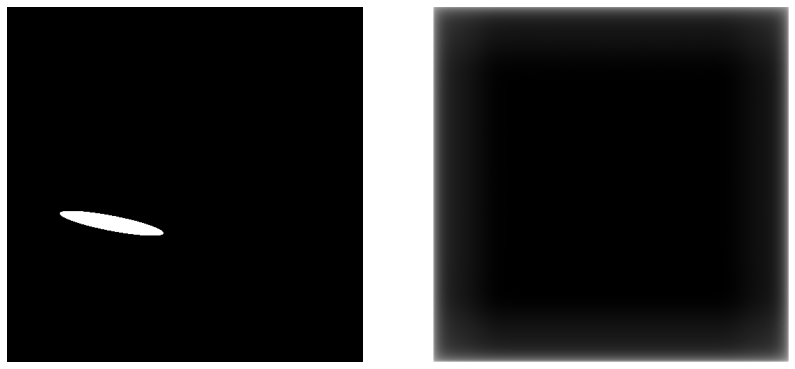

In [14]:
casae = CASAE(ae1,ae2).to(device)
with torch.no_grad():
    plt.figure(figsize=(14,7))
    image, defect_mask = next(iter(test_dataloader))
    defect_mask=defect_mask.to(device)
    image = image.to(device)
    output = casae(image)
    plt.subplot(1,2,1); draw(defect_mask[0]);
    plt.subplot(1,2,2); draw(output[0]);

In [ ]:
torch.save(casae.state_dict(), 'casae.pt')